In [1]:
import torch
import torch.nn as nn

class MusicEncoderOnlyTransformer(nn.Module):
    def __init__(self, 
                 chord_vocab_size,  # V
                 d_model=512, 
                 nhead=8, 
                 num_layers=6, 
                 dim_feedforward=2048,
                 conditioning_dim=16, 
                 device='cuda'):
        super().__init__()
        self.device = device
        self.d_model = d_model
        self.seq_len = 513  # 1 + 256 + 256

        # Embedding for condition vector (e.g., style, time sig)
        self.condition_proj = nn.Linear(conditioning_dim, d_model)

        # Melody projection: 140D binary -> d_model
        self.melody_proj = nn.Linear(140, d_model)

        # Harmony token embedding: V -> d_model
        self.harmony_embedding = nn.Embedding(chord_vocab_size, d_model)

        # Positional encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.seq_len, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, 
                                                   nhead=nhead, 
                                                   dim_feedforward=dim_feedforward,
                                                   batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Optional: output head for harmonies
        self.output_head = nn.Linear(d_model, chord_vocab_size)

    def forward(self, conditioning_vec, melody_grid, harmony_tokens=None):
        """
        conditioning_vec: (B, C)
        melody_grid: (B, 256, 140)
        harmony_tokens: (B, 256) - optional for training or inference
        """
        B = conditioning_vec.size(0)

        # Project condition: (B, d_model) → (B, 1, d_model)
        cond_emb = self.condition_proj(conditioning_vec).unsqueeze(1)

        # Project melody: (B, 256, 140) → (B, 256, d_model)
        melody_emb = self.melody_proj(melody_grid)

        # Harmony token embedding (optional for training): (B, 256) → (B, 256, d_model)
        if harmony_tokens is not None:
            harmony_emb = self.harmony_embedding(harmony_tokens)
        else:
            # Placeholder (zeros) if not provided
            harmony_emb = torch.zeros(B, 256, self.d_model, device=self.device)

        # Concatenate full input: (B, 1 + 256 + 256, d_model)
        full_seq = torch.cat([cond_emb, melody_emb, harmony_emb], dim=1)

        # Add positional encoding
        full_seq = full_seq + self.pos_embedding[:, :self.seq_len, :]

        # Transformer encode
        encoded = self.encoder(full_seq)

        # Optionally decode harmony logits (only last 256 tokens)
        harmony_output = self.output_head(encoded[:, -256:, :])  # (B, 256, V)

        return harmony_output


Text(0.5, 1.0, '[5, 5, 1, 5, 4, 2, 4, 2, 5, 5]')

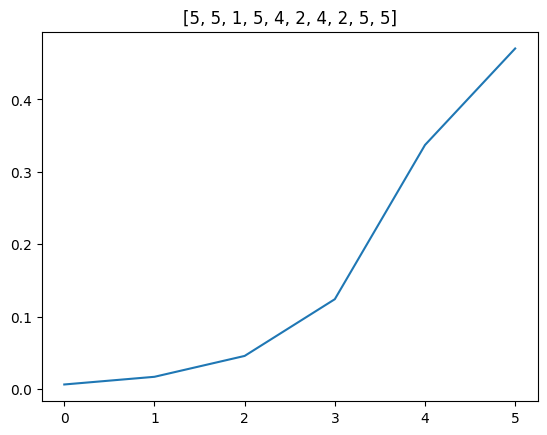

In [19]:
import matplotlib.pyplot as plt

epoch = 14
max_epoch = 15
progress = epoch / max_epoch
max_stage = 5
probs = torch.softmax(torch.tensor([
    (1.0 - abs(progress - (i / max_stage))) * 5 for i in range(max_stage + 1)
]), dim=0)

pr = []
for i in range(10):
    pr.append( torch.multinomial(probs, 1).item() )

plt.plot(probs.numpy())
plt.title(repr(pr))

In [2]:
model = MusicEncoderOnlyTransformer(chord_vocab_size=500, conditioning_dim=16)

# Dummy batch
batch_size = 4
conditioning_vec = torch.randn(batch_size, 16)
melody_grid = torch.randint(0, 2, (batch_size, 256, 140)).float()
harmony_tokens = torch.randint(0, 500, (batch_size, 256))

logits = model(conditioning_vec, melody_grid, harmony_tokens)
print(logits.shape)  # (4, 256, 500)

torch.Size([4, 256, 500])


In [4]:
import torch

def apply_structured_masking(harmony_tokens, mask_token_id, step_idx, spacing_schedule):
    """
    harmony_tokens: (B, 256) - original ground truth tokens
    mask_token_id: int - ID for the special <mask> token
    step_idx: int - 0, 1, 2, etc.
    spacing_schedule: list[int] - e.g., [16, 8, 4]

    Returns:
        masked_harmony: (B, 256) with some tokens replaced with <mask>
        target_harmony: (B, 256) with -100 at positions we do NOT want loss
    """
    B, T = harmony_tokens.shape
    assert T == 256

    device = harmony_tokens.device
    spacing = spacing_schedule[step_idx] if step_idx < len(spacing_schedule) else 1

    # Get the indices that will remain unmasked for this step
    mask = torch.ones((T,), dtype=torch.bool, device=device)  # start with all masked
    mask[::spacing] = False  # reveal tokens at spacing

    # Expand to batch
    mask = mask.unsqueeze(0).expand(B, -1)  # shape (B, 256)

    # Create masked version
    masked_harmony = harmony_tokens.clone()
    masked_harmony[mask] = mask_token_id

    # Create target (loss computed only on masked positions)
    target = harmony_tokens.clone()
    target[~mask] = -100  # ignore tokens that were shown to the model

    return masked_harmony, target


In [5]:
def train_step(model, optimizer, conditioning_vec, melody_grid, harmony_gt, step_idx, spacing_schedule, mask_token_id, loss_fn):
    """
    - step_idx: controls the masking granularity
    - model returns logits over vocab for harmony tokens
    """
    model.train()

    # Mask harmony according to schedule
    harmony_input, harmony_target = apply_structured_masking(
        harmony_tokens=harmony_gt,
        mask_token_id=mask_token_id,
        step_idx=step_idx,
        spacing_schedule=spacing_schedule
    )

    # Forward pass
    logits = model(conditioning_vec, melody_grid, harmony_input)  # (B, 256, V)

    # Compute loss only on masked tokens
    loss = loss_fn(logits.view(-1, logits.size(-1)), harmony_target.view(-1))

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


In [8]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001)

# Setup
spacing_schedule = [16, 8, 4]  # define based on time signature
mask_token_id = 499  # your chosen <mask> token in the vocab

# Dummy training step
step_idx = 1  # change dynamically for curriculum training
loss = train_step(
    model,
    optimizer,
    conditioning_vec,
    melody_grid,
    harmony_gt=harmony_tokens,
    step_idx=step_idx,
    spacing_schedule=spacing_schedule,
    mask_token_id=mask_token_id,
    loss_fn=loss_fn
)


/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
import random
from tqdm import tqdm

def get_step_idx_linear(epoch, epochs_per_stage, max_step_idx):
    return min(epoch // epochs_per_stage, max_step_idx)

def get_step_idx_mixed(epoch, max_epoch, max_step_idx):
    """Returns a random step index, biased toward early stages in early epochs."""
    progress = epoch / max_epoch
    probs = torch.softmax(torch.tensor([
        (1.0 - abs(progress - (i / max_step_idx))) * 5 for i in range(max_step_idx + 1)
    ]), dim=0)
    return torch.multinomial(probs, 1).item()

def train_with_curriculum(
    model, optimizer, dataloader, loss_fn,
    spacing_schedule, mask_token_id,
    conditioning_encoder_fn,
    epochs=10,
    curriculum_type="linear",  # "linear" or "mixed"
    epochs_per_stage=2,
):
    device = next(model.parameters()).device
    max_step_idx = len(spacing_schedule) - 1

    for epoch in range(epochs):
        model.train()

        # Determine masking level
        if curriculum_type == "linear":
            step_idx = get_step_idx_linear(epoch, epochs_per_stage, max_step_idx)
        elif curriculum_type == "mixed":
            step_idx = get_step_idx_mixed(epoch, epochs, max_step_idx)
        else:
            raise ValueError("Invalid curriculum type")

        epoch_loss = 0.0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch} (step {step_idx})"):
            melody_grid = batch["melody_grid"].to(device)           # (B, 256, 140)
            harmony_gt = batch["harmony_tokens"].to(device)         # (B, 256)
            condition_features = batch["conditioning"].to(device)  # (B, C0)

            # Encode conditioning to vector
            conditioning_vec = conditioning_encoder_fn(condition_features)  # (B, C)

            # Apply masking to harmony
            harmony_input, harmony_target = apply_structured_masking(
                harmony_gt, mask_token_id, step_idx, spacing_schedule
            )

            # Forward pass
            logits = model(conditioning_vec, melody_grid, harmony_input)

            # Compute loss only on masked tokens
            loss = loss_fn(logits.view(-1, logits.size(-1)), harmony_target.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch} | Avg Loss: {epoch_loss / len(dataloader):.4f}")


In [ ]:
spacing_schedule = [16, 8, 4]
mask_token_id = 499  # <mask> token index

train_with_curriculum(
    model=model,
    optimizer=optimizer,
    dataloader=train_loader,
    loss_fn=torch.nn.CrossEntropyLoss(ignore_index=-100),
    spacing_schedule=spacing_schedule,
    mask_token_id=mask_token_id,
    conditioning_encoder_fn=your_encoder_fn,  # maps e.g. style+time signature to (B, C)
    epochs=20,
    curriculum_type="mixed",  # or "linear"
    epochs_per_stage=3        # only for linear
)
